In [1]:
# seventeen fMRI data files from 

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
import warnings
import sys 
import os    
import scipy.io

In [4]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

Using Numpy backend.


In [5]:
fmri_bounds = np.zeros((17,43))



In [6]:
fmri_bounds= np.load('Exp2-sherlock-fmri-bounds-safe.npy')
fmri_averages=np.load('Exp2-sherlock-fmri-safe.npy')

In [7]:
#run the linear integrator
inputDataTesting=np.load("sherlock-input-data.npy")
vectorDim=100
embedding_averages = np.empty((len(inputDataTesting),vectorDim))
reservoir_averages = np.empty((len(inputDataTesting),vectorDim))


print(embedding_averages.shape)

for num in range(len(inputDataTesting)):
        if num == 0:
            embedding_averages[num] = inputDataTesting[num]
        else:
            #inputAverageTesting[num] = ((num * inputAverageTesting[num-1]) + inputDataTesting[num]) / (num + 1)
            #embedding_averages[num] = ((.75*num * embedding_averages[num-1]) + 1.25*inputDataTesting[num]) / (num + 1)
            embedding_averages[num] = inputDataTesting[num]



(1251, 100)


In [8]:
# substitute the linear integrator for the rewervoir, so we can reuse the code

reservoir_averages = embedding_averages

In [9]:
ev_fmri = brainiak.eventseg.event.EventSegment(44)
ev_fmri.fit(fmri_averages)

ev_reservoir = brainiak.eventseg.event.EventSegment(44)
ev_reservoir.fit(reservoir_averages)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=44)

In [10]:
for j in range(reservoir_averages.shape[1]):
    mean = reservoir_averages[:,j].mean()
    if abs(mean) > 0.0005:
        reservoir_averages[:,j] = reservoir_averages[:,j]/mean      

In [11]:
for j in range(fmri_averages.shape[1]):
    mean = fmri_averages[:,j].mean()
    if abs(mean) > 0.01:
        fmri_averages[:,j] = fmri_averages[:,j]/mean      

fMRI bounds  [  36   81  132  169  194  237  305  358  440  492  543  588  615  635
  651  727  762  811  845  877  941  975 1029 1086 1135 1174 1191 1267
 1295 1347 1359 1430 1484 1568 1593 1660 1707 1743 1758 1805 1873 1898
 1932]
Reservoir bounds  [  26   66   91  114  135  159  181  206  233  267  295  322  349  384
  431  451  479  510  533  563  603  631  665  696  724  758  785  806
  829  850  882  910  953  982 1007 1041 1066 1098 1130 1146 1169 1193
 1228]


Text(0.5, 1.0, 'D. Segmentation overlap for Integrator and fMRI')

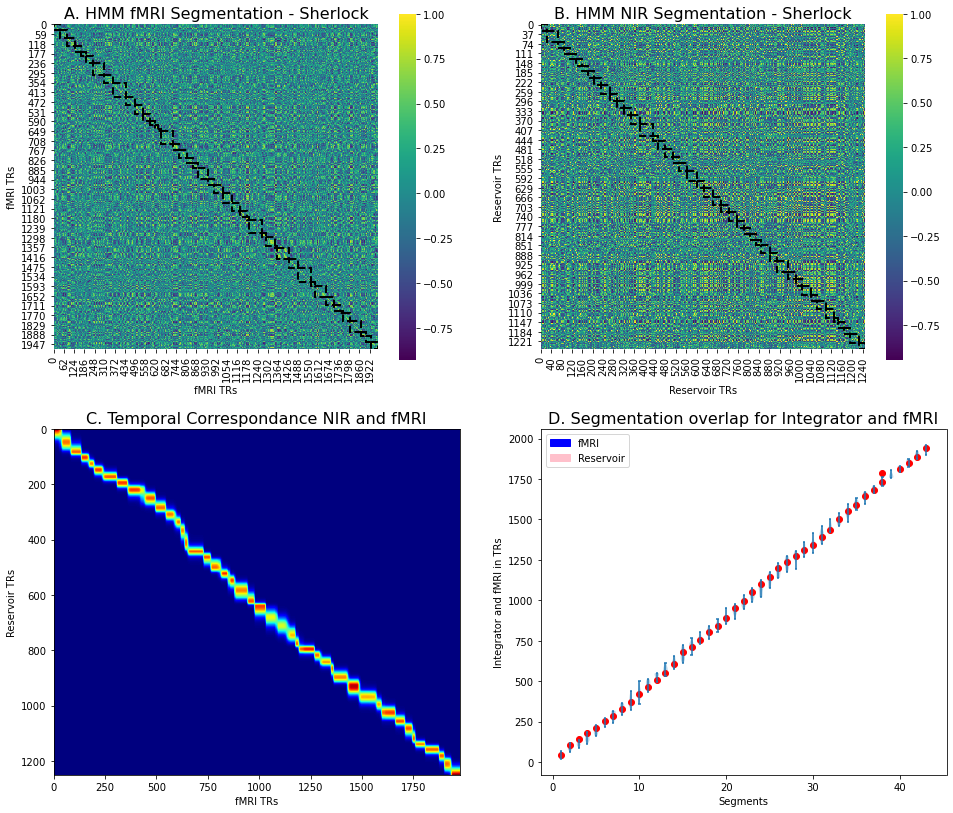

In [12]:
plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.5
scale2=0.9
nTR=1976

#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')
#plt.imshow(np.corrcoef(BOLD.mean(2).T))

sns.heatmap(np.corrcoef(fmri_averages),cmap='viridis', square=True)


bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.title('A. HMM fMRI Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,2)

sns.heatmap(np.corrcoef(reservoir_averages),cmap='viridis', square=True)


nTR=1251
bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.title('B. HMM NIR Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,3)

plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')

plt.title('C. Temporal Correspondance NIR and fMRI', fontsize = 16)



plt.subplot(2,2,4)
reps=16

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds[:reps])


axis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
       21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,38,40,41,42,43]
plt.scatter(axis, bounds/1251*1976, color='r')

plt.xlabel('Segments')
plt.ylabel('Integrator and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.title('D. Segmentation overlap for Integrator and fMRI', fontsize = 16)




#fig.tight_layout()
#plt.savefig('Exp2-replication-sherlock44.png', dpi=600)


In [13]:
print(fmri_bounds.shape)
print(fmri_bounds)

(17, 43)
[[  27.   77.   98.  114.  222.  269.  302.  344.  361.  420.  495.  546.
   561.  586.  614.  716.  731.  758.  855.  882.  945.  964.  988. 1019.
  1074. 1138. 1175. 1194. 1266. 1294. 1351. 1430. 1476. 1526. 1598. 1671.
  1709. 1733. 1778. 1806. 1855. 1926. 1949.]
 [  25.   76.  131.  162.  217.  240.  306.  337.  357.  409.  472.  528.
   596.  613.  636.  726.  748.  822.  850.  886.  945.  975. 1030. 1073.
  1106. 1170. 1192. 1266. 1301. 1343. 1388. 1425. 1506. 1573. 1631. 1662.
  1690. 1742. 1778. 1805. 1870. 1882. 1953.]
 [  37.   63.  110.  136.  173.  251.  312.  348.  362.  405.  505.  525.
   544.  605.  643.  738.  762.  803.  840.  895.  926.  963. 1018. 1031.
  1088. 1143. 1217. 1267. 1315. 1346. 1386. 1447. 1483. 1531. 1574. 1654.
  1710. 1727. 1761. 1832. 1876. 1897. 1935.]
 [  64.  108.  136.  170.  188.  235.  265.  312.  348.  417.  492.  546.
   572.  616.  639.  729.  756.  805.  841.  876.  911.  944. 1027. 1069.
  1149. 1192. 1246. 1289. 1348. 1416. 1459

In [14]:
print(ev_reservoir.ll_[len(ev_reservoir.ll_)-1])
print(ev_fmri.ll_[len(ev_fmri.ll_)-1])

[-2106.2855828]
[-3153.01262267]


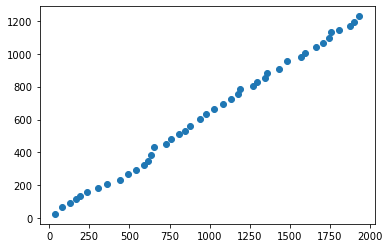

In [15]:
x = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
y = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
plt.scatter(x,y)

p = 0.9674945568359707


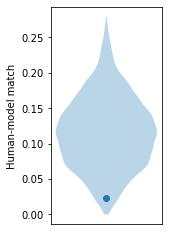

In [16]:


bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
h_bounds = h_bounds/1251*1976


np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in h_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(h_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))